# Differential expression analysis

We will move on to another set of quantitative techniques: differential gene expression analysis. Our goal will be to find diet-associated changes in the mice's transcriptome.

Yesterday we were looking for genotype associated changes in continuous phenotypes. Conceptually, today's material isn't too different: we will continue to analyze the association between a categorical condition (CD/HFD diet) with continuous outcomes (gene expression levels) but we will do it on larger scale data of homogenous nature.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

## Download the gene expression data

To spare you finding them in the supplementary material, here is the direct link to the file: http://science.sciencemag.org/highwire/filestream/680254/field_highwire_adjunct_files/5/aad0189_DataFileS5.xlsx

Store it alongside the previously downloaded data.

In [2]:
# load gene expression data
df = pd.read_excel("../example_data/aad0189_DataFileS5.xlsx",header=2, index_col=0)

## Data wrangling

For some more information on and examples of the plot types we will use here, see:<br>
http://www.arrayanalysis.org/main.html

### 1.1: Read in aad0189_DataFileS5.xlsx with pandas
Open the spreadsheet in Excel beforehand. Notice that the headers aren't in the first row, so use the `header` keyword to specify the header's line number for `read_excel()`.

In [3]:
df.fillna(0).head()

,MATCH_ORDER,Gene,Probeset,Gene.1,Protein,Unnamed: 6,Range CD,Range HFD,Range_All,C57BL/6J_Liver_CD,...,BXD89_Liver_HFD,BXD90_Liver_HFD,BXD95_Liver_HFD,BXD96_Liver_HFD,BXD97_Liver_HFD,BXD98_Liver_HFD,BXD99_Liver_HFD,BXD100_Liver_HFD,BXD101_Liver_HFD,BXD103_Liver_HFD
Original_Order,,,,,,,,,,,,,,,,,,,,,
12643,0.0,Igh,10403036,Igh,0,0.0,1.495886,1.720705,1.720705,5.138,...,4.959,5.483,5.347,5.087,5.125,5.160,5.020,5.170,4.775,4.982
12646,0.0,Igh,10403043,Igh,0,0.0,2.938337,1.988940,3.595021,7.983,...,7.415,7.252,7.547,7.358,7.424,7.447,7.567,7.732,7.365,7.369
12653,0.0,Igh,10403063,Igh,0,0.0,3.719220,1.859610,4.260433,7.169,...,6.665,6.948,6.999,6.974,6.886,6.876,7.027,7.093,6.748,6.771
8759,1458.0,Hcfc2,10365242,Hcfc2,A0AUN4,0.0,1.479388,1.465101,1.536875,9.241,...,9.177,9.021,8.803,8.928,8.914,8.838,9.056,8.924,8.945,8.865
18740,8191.0,Ccdc112,10458794,Ccdc112,A0AUP1,0.0,1.834008,1.943962,1.997229,6.761,...,6.623,6.371,6.187,6.310,6.448,6.531,6.167,6.401,6.470,6.565


### 1.2: Calculate gene-wise average expression values, and clean up

The expression of many genes were measured by multiple probes on the microarray. We would like to reduce the complexity of the data, and have only one, averaged expression row per gene. You can use the `groupby` function to achieve this, but make sure to use the `Gene.1` column instead of `Gene`. They are identical for the majority of rows, but `Gene.1` will be better for us later.

The expression values are stored in the columns that contain the string `Liver`, so use the `filter` method to keep only those columns. Finally, remove that `_Liver` substring from the column names. Call the resulting dataframe `expr`.

In [4]:
# extract liver and replace str
expr = df.groupby('Gene.1').mean().filter(regex='Liver',axis=1)
expr.columns = expr.columns.str.replace('_Liver', '')
expr

,C57BL/6J_CD,DBA/2J_CD,BXD43_CD,BXD44_CD,BXD45_CD,BXD48_CD,BXD49_CD,BXD51_CD,BXD55_CD,BXD56_CD,...,BXD89_HFD,BXD90_HFD,BXD95_HFD,BXD96_HFD,BXD97_HFD,BXD98_HFD,BXD99_HFD,BXD100_HFD,BXD101_HFD,BXD103_HFD
Gene.1,,,,,,,,,,,,,,,,,,,,,
544988,6.1830,6.353333,6.262333,6.263667,6.270,6.201333,6.2370,6.274667,6.319,6.2710,...,6.364333,6.339333,6.397667,6.3280,6.280333,6.385333,6.460667,6.331667,6.216667,6.278333
100043387,10.3840,9.848000,10.108000,9.860000,9.392,9.926000,10.1050,10.040000,10.128,9.4100,...,10.088000,10.553000,9.556000,10.6320,10.427000,10.217000,10.140000,10.639000,10.223000,9.956000
0610007C21Rik,12.3890,12.559000,12.647000,12.639000,12.515,12.659000,12.5710,12.512000,12.651,12.5290,...,12.608000,12.593000,12.792000,12.5730,12.690000,12.700000,12.628000,12.550000,12.660000,12.696000
0610007L01Rik,10.2875,10.390000,10.411000,10.419500,10.306,10.432000,10.2005,10.432000,10.320,10.2945,...,10.280000,10.309000,10.466500,10.1370,10.122000,10.179500,10.370000,10.275000,10.048000,10.154500
0610007P08Rik,8.1160,8.422000,8.235000,8.135000,8.198,8.092500,8.1460,7.876500,8.400,8.0930,...,8.265500,8.275500,7.796000,8.2495,8.297000,8.058000,7.978000,8.148500,8.191000,8.272000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3,10.1750,10.361000,10.231000,10.146000,10.261,10.331000,10.6900,10.334000,10.336,10.2200,...,10.079000,10.213000,10.133000,10.2700,10.333000,10.179000,10.075000,10.090000,10.108000,10.182000
a,6.9390,7.398000,7.447000,7.552000,7.600,7.744000,7.1580,7.310000,7.088,7.6100,...,7.727000,7.143000,7.683000,7.1850,7.036000,7.074000,7.513000,7.241000,7.226000,7.283000
l7Rn6,9.8850,9.945000,10.123000,9.319000,9.510,9.606000,9.8760,9.898000,9.786,9.8380,...,9.853000,10.096000,9.626000,9.9960,9.947000,9.992000,9.916000,9.907000,9.918000,9.748000


## Task 1: Inspecting data consistency and normalization

### 1.3.1: Create a ratio-intensity plot a.k.a. MA plot
The ratio intensity plot compares two microarrays with each other to detect systematic calibration differences between them, and therefore it's an important tool for microarray normalization. When we have so many microarrays (80+ in this case) it is practical to take one as the reference, and compare + normalize the rest against it. For simplicity, we will just compare a single pair now -- the rest would be the same.

Pick any two microarray measurements (columns) from the `expr` DataFrame.

The ratio intensity plot shows the log2 expression ratio of each pair of corresponding probes as a function of their expression (light intensity) on a scatter plot. Since the data you're working with has already been log2-transformed (common practice in microarray experiments) the "ratio" is in fact the *difference* of the values, since log(x1/x2) = log(x1)-log(x2).

Depending on your computer, the scatter plot may take a while to draw, so you can cheat a bit and plot only every 10th data point. You can use `.iloc[::10]` to achieve this.

You should also add a reference line at zero, and a (fancy kind of) rolling average of the points using `nonparametric.lowess` from the module `statsmodels.api` (already imported as `sm`).

In [5]:
# choose x and y, because it is form of log2, so just add and substract
[a, b] = np.random.randint(expr.shape[1], size=2)
x = expr.iloc[:,a]
y = expr.iloc[:,b]
z = sm.nonparametric.lowess(x-y, 1/2*(x+y))

Text(0, 0.5, 'log ratio (M)')

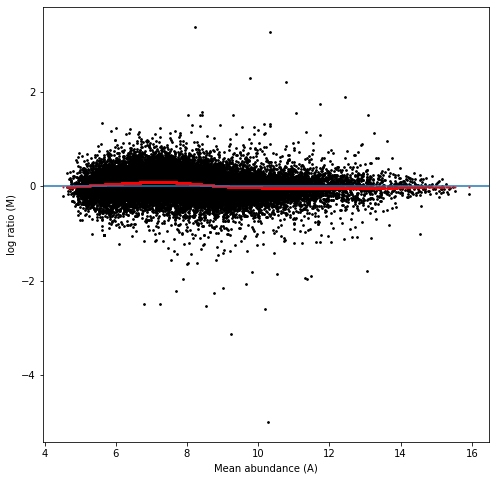

In [6]:
# plot ratio-intensity plot
fig = plt.figure(figsize=(8,8))
plt.axhline(0)
plt.scatter(1/2*(x+y),x-y, c='k', s=3)
plt.scatter(z[:,0],z[:,1], c='r', s=1)
plt.xlabel('Mean abundance (A)')
plt.ylabel('log ratio (M)')

### 1.3.2: Implement a Relative Log Expression (RLE) box plot
The Relative Log Expression (RLE) values are the log2-ratios of individual gene expression values versus the median expression of the gene across all experiments. (Reminder once again: the expression values are log2-transformed, so their ratio means difference in practice).

It is assumed that most genes are not systematically over- or underexpressed across the arrays, so we expect these log2-ratios to be centered around 0 for every array, with similar standard deviations.

By creating a box-plot out of the RLE values for every array, we can get visual confirmation whether this is the case, and the arrays had been normalized consistently.

In [7]:
# doing normalize, calculate each gene median, and substract column and column
expr.subtract(expr.median(axis=1), axis=0)

,C57BL/6J_CD,DBA/2J_CD,BXD43_CD,BXD44_CD,BXD45_CD,BXD48_CD,BXD49_CD,BXD51_CD,BXD55_CD,BXD56_CD,...,BXD89_HFD,BXD90_HFD,BXD95_HFD,BXD96_HFD,BXD97_HFD,BXD98_HFD,BXD99_HFD,BXD100_HFD,BXD101_HFD,BXD103_HFD
Gene.1,,,,,,,,,,,,,,,,,,,,,
544988,-0.1320,0.038333,-0.052667,-0.051333,-0.045,-0.113667,-0.0780,-0.040333,0.004,-0.0440,...,0.049333,0.024333,0.082667,0.0130,-0.034667,0.070333,0.145667,0.016667,-0.098333,-0.036667
100043387,0.2560,-0.280000,-0.020000,-0.268000,-0.736,-0.202000,-0.0230,-0.088000,0.000,-0.7180,...,-0.040000,0.425000,-0.572000,0.5040,0.299000,0.089000,0.012000,0.511000,0.095000,-0.172000
0610007C21Rik,-0.2280,-0.058000,0.030000,0.022000,-0.102,0.042000,-0.0460,-0.105000,0.034,-0.0880,...,-0.009000,-0.024000,0.175000,-0.0440,0.073000,0.083000,0.011000,-0.067000,0.043000,0.079000
0610007L01Rik,0.0045,0.107000,0.128000,0.136500,0.023,0.149000,-0.0825,0.149000,0.037,0.0115,...,-0.003000,0.026000,0.183500,-0.1460,-0.161000,-0.103500,0.087000,-0.008000,-0.235000,-0.128500
0610007P08Rik,-0.1190,0.187000,0.000000,-0.100000,-0.037,-0.142500,-0.0890,-0.358500,0.165,-0.1420,...,0.030500,0.040500,-0.439000,0.0145,0.062000,-0.177000,-0.257000,-0.086500,-0.044000,0.037000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zzz3,-0.0320,0.154000,0.024000,-0.061000,0.054,0.124000,0.4830,0.127000,0.129,0.0130,...,-0.128000,0.006000,-0.074000,0.0630,0.126000,-0.028000,-0.132000,-0.117000,-0.099000,-0.025000
a,-0.3390,0.120000,0.169000,0.274000,0.322,0.466000,-0.1200,0.032000,-0.190,0.3320,...,0.449000,-0.135000,0.405000,-0.0930,-0.242000,-0.204000,0.235000,-0.037000,-0.052000,0.005000
l7Rn6,-0.0130,0.047000,0.225000,-0.579000,-0.388,-0.292000,-0.0220,0.000000,-0.112,-0.0600,...,-0.045000,0.198000,-0.272000,0.0980,0.049000,0.094000,0.018000,0.009000,0.020000,-0.150000


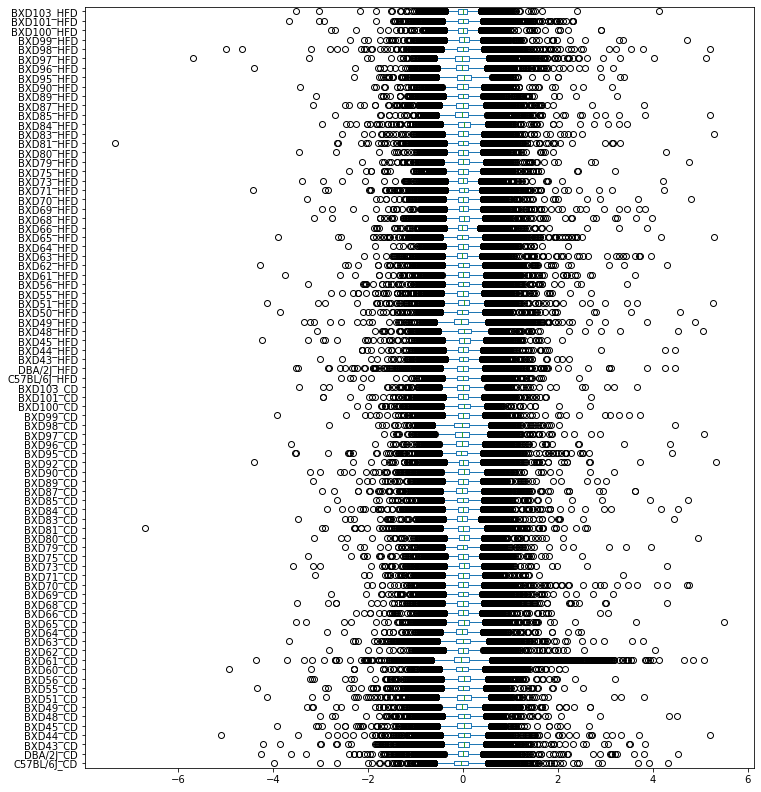

In [8]:
# plot box plot with normalize data
(expr.subtract(expr.median(axis=1), axis=0)).plot(kind='box', vert=False, figsize=(12,14))
# plt.ylabel(expr.columns)
plt.show()

### 1.3.3: Do you consider it necessary to perform a quantile normalization for the microarrays?

Are there any microarrays with systematically higher or lower expression values that the rest?

- Yes, bacause if we didn't do normalization, all data will plot in different scale, and it is hard to see anything.

## Task 2: Which statistical test to choose?

We want to infer differentially expressed genes between the CD and the HFD condition. Therefore we treat the expression values of all the strains for a given gene under one diet as independent observations of the same random variable (i.e. we ignore variation caused by genetics and focus on variation caused by the diet). We then compare these distributions between the two diets with a statistical test to see whether their means differ significantly or not.

Since most statistical tests assume certain properties of the compared distributions, we'll first have to find out which of these assumptions are true for our data. This way we can choose a suitable test for differential expression detection. We will limit ourselves to the following mean-equality tests:

* Student's t-test (assumes distributions are normally distributed and have equal variance, has highest statistical power)
* Welch's t-test (assumes normal distribution, does not assume equal variance, slightly lower statistical power) 
* Mann-Whitney U-test or its matched-samples equivalent Wilcoxon's rank-sum test (no assumptions about the tested distributions, weakest statistical power)

### 2.0: Separate the CD and HFD samples in the expression DataFrame
Since you will have to compare expression values of CD samples with those from HFD samples, you have to be able to access them separately. You can reuse the `split_cd_hfd` function from Friday, and store the resulting DataFrame in `expr2`. How many samples did we lose? We will accept this trade-off for simplicity now.

Remember why the diet-inclusive MultiIndex is useful: if you ever need to extract the CD or HFD samples into a separate DataFrames, you can always do it with the cross-section opreator: `expr2_cd = expr2.xs('CD', level='diet')`. And if you want to revert to the original layout, you can do `expr2.unstack()`.

In [9]:
def split_cd_hfd(input_df):
    input_df.index.name = 'gene'  # rows are genes now
    input_cd = input_df.filter(regex=r'_CD|CD_')
    input_hfd = input_df.filter(regex=r'_HFD|HFD_')

    input_cd.columns = input_cd.columns.str.replace(r'_CD|CD_', '')
    input_hfd.columns = input_hfd.columns.str.replace(r'_HFD|HFD_', '')
    
    input_cd.insert(0, 'diet', 'CD')
    input_hfd.insert(0, 'diet', 'HFD')
    
    kept_columns = input_cd.columns.intersection(input_hfd.columns)
    
    df_both = pd.concat([input_cd, input_hfd], sort=False)[kept_columns]
    df_both.columns.name = 'strain'  # columns are strains now
    
    return df_both.reset_index().set_index(['gene', 'diet']).sort_index()

In [10]:
expr2 = split_cd_hfd(expr)
expr2

strain               C57BL/6J     DBA/2J      BXD43      BXD44      BXD45  \
gene          diet                                                          
544988        CD     6.183000   6.353333   6.262333   6.263667   6.270000   
              HFD    6.365333   6.348333   6.301333   6.345667   6.350667   
100043387     CD    10.384000   9.848000  10.108000   9.860000   9.392000   
              HFD   10.215000  10.153000  10.361000  10.044000   9.736000   
0610007C21Rik CD    12.389000  12.559000  12.647000  12.639000  12.515000   
...                       ...        ...        ...        ...        ...   
l7Rn6         HFD    9.950000  10.169000  10.146000   9.376000   9.857000   
mCG_21548     CD     7.335000   7.801000   7.789000   7.708000   7.703000   
              HFD    7.634000   7.720000   7.851000   7.811000   7.968000   
rp9           CD     9.943000   9.795000   9.860000   9.715000   9.772000   
              HFD    9.811000   9.743000   9.765000   9.804000   9.683000   

strain                  BXD48      BXD49      BXD51      BXD55      BXD56  \
gene          diet                                                          
544988        CD     6.201333   6.237000   6.274667   6.319000   6.271000   
              HFD    6.285667   6.207667   6.362667   6.474667   6.427333   
100043387     CD     9.926000  10.105000  10.040000  10.128000   9.410000   
              HFD   10.108000  10.195000  10.155000   9.979000   9.786000   
0610007C21Rik CD    12.659000  12.571000  12.512000  12.651000  12.529000   
...                       ...        ...        ...        ...        ...   
l7Rn6         HFD    9.813000   9.811000  10.025000  10.012000   9.782000   
mCG_21548     CD     7.677000   7.767000   7.844000   7.933000   7.451000   
              HFD    8.004000   7.537000   7.698000   7.570000   7.695000   
rp9           CD     9.743000   9.951000   9.618000   9.856000   9.658000   
              HFD    9.666000   9.868000   9.581000   9.832000   9.848000   

strain              ...      BXD89      BXD90      BXD95   BXD96      BXD97  \
gene          diet  ...                                                       
544988        CD    ...   6.300667   6.274667   6.345000   6.283   6.294333   
              HFD   ...   6.364333   6.339333   6.397667   6.328   6.280333   
100043387     CD    ...  10.091000  10.015000  10.484000  10.306  10.306000   
              HFD   ...  10.088000  10.553000   9.556000  10.632  10.427000   
0610007C21Rik CD    ...  12.815000  12.761000  12.473000  12.583  12.441000   
...                 ...        ...        ...        ...     ...        ...   
l7Rn6         HFD   ...   9.853000  10.096000   9.626000   9.996   9.947000   
mCG_21548     CD    ...   7.646000   7.909000   7.654000   7.543   7.419000   
              HFD   ...   7.679000   7.786000   7.753000   7.672   7.664000   
rp9           CD    ...   9.848000   9.887000   9.668000   9.719   9.693000   
              HFD   ...   9.663000   9.943000   9.473000   9.734   9.763000   

strain                  BXD98      BXD99     BXD100     BXD101     BXD103  
gene          diet                                                         
544988        CD     6.268667   6.219000   6.332333   6.432667   6.428333  
              HFD    6.385333   6.460667   6.331667   6.216667   6.278333  
100043387     CD    10.438000  10.063000  10.260000   9.832000   9.898000  
              HFD   10.217000  10.140000  10.639000  10.223000   9.956000  
0610007C21Rik CD    12.612000  12.534000  12.721000  12.661000  12.583000  
...                       ...        ...        ...        ...        ...  
l7Rn6         HFD    9.992000   9.916000   9.907000   9.918000   9.748000  
mCG_21548     CD     7.314000   7.820000   8.143000   7.901000   8.034000  
              HFD    7.721000   7.873000   7.821000   7.541000   7.846000  
rp9           CD     9.959000   9.764000   9.766000   9.732000   9.715000  
              HFD    9.822000   9.693000   9.600000   9.

In [11]:
print('the number of missing column data:', expr.shape[1] - expr2.shape[1]*2)

the number of missing column data: 3


### 2.1: Assumption testing: do the CD and HFD samples have equal variance?

### 2.1.1: Choose any gene
Store the gene name (or the numeric index of the row) you chose in the variable `gene`, so we can reproduce it later.

In [12]:
gene = expr2.loc[[544988]]
gene

strain       C57BL/6J    DBA/2J     BXD43     BXD44     BXD45     BXD48  \
gene   diet                                                               
544988 CD    6.183000  6.353333  6.262333  6.263667  6.270000  6.201333   
       HFD   6.365333  6.348333  6.301333  6.345667  6.350667  6.285667   

strain          BXD49     BXD51     BXD55     BXD56  ...     BXD89     BXD90  \
gene   diet                                          ...                       
544988 CD    6.237000  6.274667  6.319000  6.271000  ...  6.300667  6.274667   
       HFD   6.207667  6.362667  6.474667  6.427333  ...  6.364333  6.339333   

strain          BXD95  BXD96     BXD97     BXD98     BXD99    BXD100  \
gene   diet                                                            
544988 CD    6.345000  6.283  6.294333  6.268667  6.219000  6.332333   
       HFD   6.397667  6.328  6.280333  6.385333  6.460667  6.331667   

strain         BXD101    BXD103  
gene   diet                      
544988 CD    6.432667  6.428333  
       HFD   6.216667  6.278333  

[2 rows x 39 columns]

### 2.1.2: Use the appropriate statistical test to check whether the samples have equal variance
You have to compare the expression values of this gene between the `CD` and `HFD` measurements. The Levene-test is suitable, and it's implemented in `scipy.stats`. How do you interpret its output p-value?

- The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
- Hence, there is not sufficient evidence that the two samples have different variances Share

In [13]:
gene_cd = gene.loc[(544988, 'CD')]
gene_hfd = gene.loc[(544988, 'HFD')]
stats.levene(gene_cd, gene_hfd)[1]

0.6001438152827027

### 2.1.3: Perform the test on all genes, and draw a p-value histogram

To assess the overall situation, run the equal variance test for all genes, plot the histogram of the raw p-values, and draw a conclusion. Can we assume equal variance?

- Only few hist under p=0.05, hence, we can say CD and HFD have same variance.

In [14]:
def levene(gene):
    gene_cd = gene.loc[gene.index[0]]
    gene_hfd = gene.loc[gene.index[1]]
    return stats.levene(gene_cd, gene_hfd)[1]

In [15]:
pvals = expr2.groupby("gene").apply(levene)

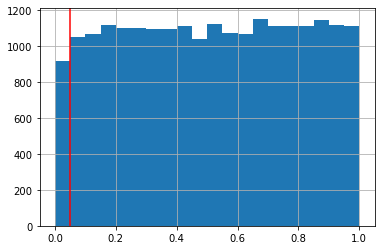

In [16]:
pvals.hist(bins=20)
plt.axvline(0.05, c='r')

### 2.2 Assumption testing: are the CD and HFD samples normally distributed?

- Cause they have same variance, so if the mean is also equal, then CD and HFD have same normal distribute.

###  2.2.1: Find an appropriate statistical test to answer whether the samples are normally distributed
`scipy.stats` can help you with this one too. First, do it for just one gene, like you did in 2.1.2.

In [17]:
print('the p value of CD data are normally distributed:',stats.normaltest(gene_cd)[1])

the p value of CD data are normally distributed: 2.8370500673890536e-07


In [18]:
print('the p value of HFD data are normally distributed:',stats.normaltest(gene_hfd)[1])

the p value of HFD data are normally distributed: 0.6419061527199216


###  2.2.2: Perform the test on all genes, and draw a p-value histogram

What does the histogram look like for this one? How does this affect your options?

In [19]:
def normaltest(gene, method):
    return stats.normaltest(gene.loc[gene.index[0][0], method])[1]

In [20]:
normalpvals_cd = expr2.groupby("gene").apply(normaltest, method='CD')
normalpvals_hfd = expr2.groupby("gene").apply(normaltest, method='HFD')

In [21]:
normalpvals_cd.head()

gene
544988           2.837050e-07
100043387        6.737051e-02
0610007C21Rik    7.271819e-01
0610007L01Rik    4.414608e-01
0610007P08Rik    6.687102e-01
dtype: float64

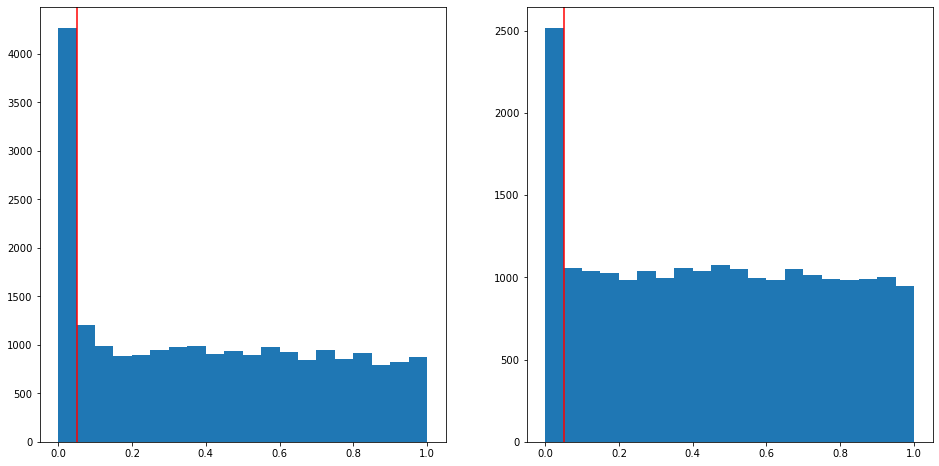

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,8))
ax1.hist(normalpvals_cd, bins=20)
ax2.hist(normalpvals_hfd, bins=20)
ax1.axvline(0.05, c='r')
ax2.axvline(0.05, c='r')
plt.show()

### 2.3: In light of the tested assumptions, choose a testing strategy for identifying differences in the expression means of the CD and HFD samples

Don't write code, just find the right test(s), and discuss how you would proceed with the analysis. Your trade-off is between statistical power and statistical soundness. Can you have the best of both worlds?

In here, I think I will try to use Kolmogorov–Smirnov test, which can check whether two data have same distribution, and if p value is significant, then I will say it exist some difference bewteen them.

## Task 3: Differential expression testing

Having checked the assumptions that our data fulfill, it's time to settle on a statistical test to compare gene expression values between the CD and HFD conditions.

We would like you to end up with a DataFrame `diffexpr`, which is indexed by gene identifiers, and has at least three columns:
* log2 fold change between CD and HFD means
* raw p-values of the mean-equality test that you chose
* B-H corrected p-values of the test

If you have enough time, you can add the raw and corrected p-values of other mean-equality tests as well, and compare them with each other, or select the appropriate one gene-by-gene based on your assumption tests in Task 2.

In [23]:
# calculate differential expression of each gene
log2fc=expr2.xs('CD', level='diet').mean(axis=1)-expr2.xs('HFD', level='diet').mean(axis=1)
log2fc

gene
544988          -0.041726
100043387       -0.094410
0610007C21Rik   -0.011872
0610007L01Rik    0.007372
0610007P08Rik   -0.061718
                   ...   
Zzz3             0.153692
a               -0.059923
l7Rn6           -0.122462
mCG_21548       -0.051026
rp9              0.046385
Length: 21835, dtype: float64

In [24]:
# try different way to check p values
wilcoxon_pvals = expr2.groupby('gene').apply(lambda x: stats.wilcoxon(x.iloc[0], x.iloc[1])[1])
ttest_pvals = expr2.groupby('gene').apply(lambda x: stats.ttest_ind(x.iloc[0], x.iloc[1])[1])
mwu_pvals = expr2.groupby('gene').apply(lambda x: stats.mannwhitneyu(x.iloc[0], x.iloc[1], alternative="two-sided")[1])

In [25]:
diffexpr = pd.DataFrame()
diffexpr['log2fc'] = log2fc
diffexpr['wilcoxon pvals'] = wilcoxon_pvals
diffexpr['ttest pvals'] = ttest_pvals
diffexpr['mwu pvals'] = mwu_pvals
diffexpr

,log2fc,wilcoxon pvals,ttest pvals,mwu pvals
gene,,,,
544988,-0.041726,0.007690,2.471637e-02,2.461669e-03
100043387,-0.094410,0.029482,1.105006e-01,1.588075e-01
0610007C21Rik,-0.011872,0.504683,5.986195e-01,3.684131e-01
0610007L01Rik,0.007372,0.530015,6.891828e-01,9.561658e-01
0610007P08Rik,-0.061718,0.030539,6.733311e-02,4.618156e-02
...,...,...,...,...
Zzz3,0.153692,0.000002,2.316426e-07,9.252459e-07
a,-0.059923,0.121381,1.713445e-01,2.760128e-01
l7Rn6,-0.122462,0.000965,8.665480e-03,1.454909e-02


In [26]:
# using BH to correct p values
from statsmodels.sandbox.stats.multicomp import multipletests
diffexpr['wilcoxon pvals corr'] = multipletests(diffexpr['wilcoxon pvals'], method='fdr_bh')[1]
diffexpr['ttest pvals corr'] = multipletests(diffexpr['ttest pvals'], method='fdr_bh')[1]
diffexpr['mwu pvals corr'] = multipletests(diffexpr['mwu pvals'], method='fdr_bh')[1]
diffexpr

,log2fc,wilcoxon pvals,ttest pvals,mwu pvals,wilcoxon pvals corr,ttest pvals corr,mwu pvals corr
gene,,,,,,,
544988,-0.041726,0.007690,2.471637e-02,2.461669e-03,0.016986,0.051565,0.007086
100043387,-0.094410,0.029482,1.105006e-01,1.588075e-01,0.053852,0.179216,0.238169
0610007C21Rik,-0.011872,0.504683,5.986195e-01,3.684131e-01,0.584529,0.688445,0.468540
0610007L01Rik,0.007372,0.530015,6.891828e-01,9.561658e-01,0.607698,0.765220,0.971427
0610007P08Rik,-0.061718,0.030539,6.733311e-02,4.618156e-02,0.055444,0.119326,0.085016
...,...,...,...,...,...,...,...
Zzz3,0.153692,0.000002,2.316426e-07,9.252459e-07,0.000021,0.000002,0.000008
a,-0.059923,0.121381,1.713445e-01,2.760128e-01,0.178872,0.256500,0.372528
l7Rn6,-0.122462,0.000965,8.665480e-03,1.454909e-02,0.002906,0.021283,0.032398


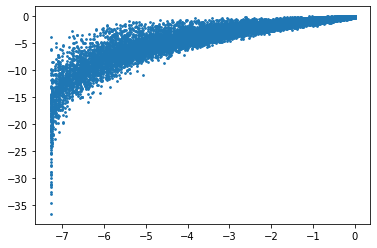

In [27]:
# plot the scatter plot
plt.scatter(np.log10(diffexpr['wilcoxon pvals']), np.log10(diffexpr['ttest pvals']), s=3)

## Task 4: Volcano plots

Volcano plots visualize two key aspects of a differential expression experiment at once on a single scatter plot: the significance of differential expression as a function of the log2 fold change between the two conditions.
For a more detailed description:

* https://en.wikipedia.org/wiki/Volcano_plot_(statistics)

### 4.1:  Implement a Volcano plot
Use `matplotlib` instead of `seaborn` for customizability: try to include cut-off lines and highlight significant genes (above the cut-off in statistical significance AND fold change) with a different color. Feel free to introduce an extra column in `diffexpr` if it helps you achieve that.

In [28]:
# setting label
label = []
highlight = [2, -0.2, 0.2]
for index, row in diffexpr.iterrows():
    if -np.log10(row['mwu pvals corr']) < highlight[0]:
        label.append('grey')
    elif highlight[1] < row['log2fc'] < highlight[2]:
        label.append('grey')
    elif row['log2fc'] > 0:
        label.append('green')
    else:
        label.append('red')

In [29]:
diffexpr['is_de'] = [True if x == 'grey' else False for x in label]
(diffexpr['is_de'] == True).sum()

18793

Text(0, 0.5, '-log 10 p values')

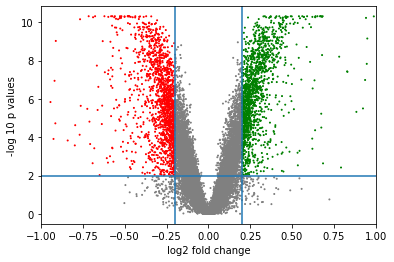

In [30]:
# plot volcano plot
plt.scatter(diffexpr['log2fc'], -np.log10(diffexpr['mwu pvals corr']), s=1, color=label)
plt.xlim(-1,1)
plt.axhline(highlight[0])
plt.axvline(highlight[1])
plt.axvline(highlight[2])
plt.xlabel('log2 fold change')
plt.ylabel('-log 10 p values')

### 4.2: Interpret the Volcano plot
Why doesn't fold change and significance correlate perfectly? Can you explain the points on either side of the main "lava spray"?

Optional: pick an outliers on one side of the main cluster, and create a good old double histogram with the CD and HFD expression values. Now pick a point from the other side, create a similar histogram for that too, and compare the two.

variance

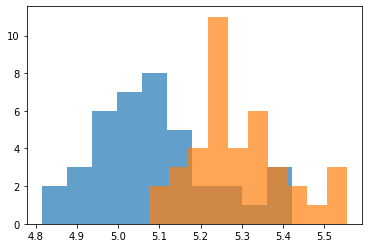

In [35]:
diffexpr['label'] = label
gene = diffexpr.loc[diffexpr['label'] == 'red'].index[1000]
plt.hist(expr2.loc[gene, 'CD'], alpha=0.7)
plt.hist(expr2.loc[gene, 'HFD'], alpha=0.7)
plt.show()

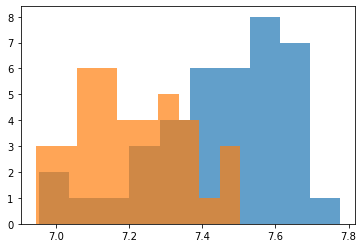

In [36]:
gene = diffexpr.loc[diffexpr['label'] == 'green'].index[1000]
plt.hist(expr2.loc[gene, 'CD'], alpha=0.7)
plt.hist(expr2.loc[gene, 'HFD'], alpha=0.7)
plt.show()

### 4.3 Export your `diffexpr`  DataFrame as a csv file for later use

In [37]:
diffexpr.to_csv('..\output\diffexpr.csv')

## Task 5: Expression heatmaps
    
Heatmaps are a standard way of visualizing the expression of multiple genes across a set of samples, especially if one is interested in the expression signatures associated with different conditions. Heatmap visualization is often combined with clustering in order to group genes and/or samples with similar expression profiles together, therefore we will use seaborn's `clustermap` to do the job.

Since the number of measured genes is very high (20,000+) in our experiment, it isn't practical to place them all on a heat map. 

### 5.1: Heatmap with a small selection of genes

The heatmap's rows should be genes, and the columns should be samples -- this includes both CD and HFD samples. So you will first have to `unstack` those double diet rows produced by the `split_cd_hfd` transformation. This way your columns will contain all strains under both dietary conditions.

For a start, limit yourself to every 100th gene and create a clustered heatmap out of their expression values.

Does this visualization seem useful to you? Why not?

- No, because the scale is too large, so we need to normalize data first.

C:\Users\Tung\PyMOL\lib\site-packages\seaborn\matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


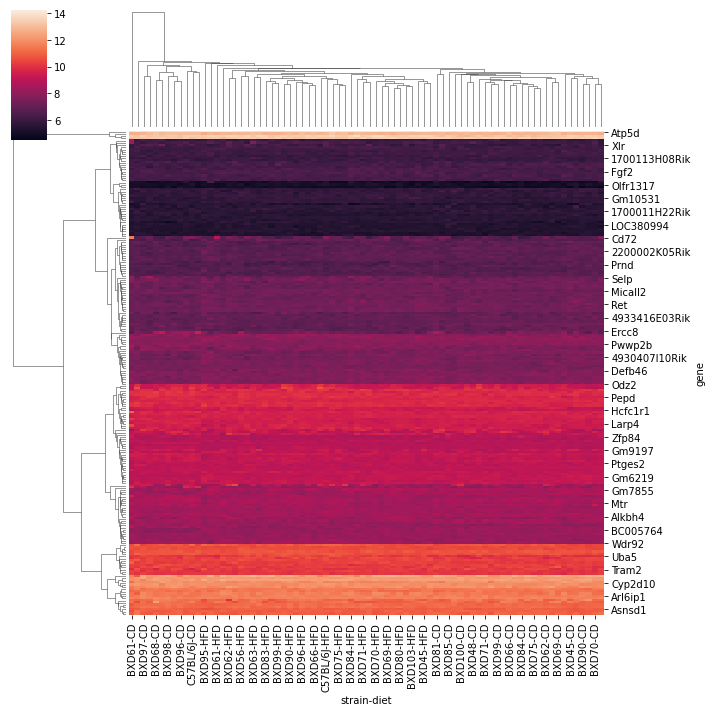

In [38]:
expr2_trans = expr2.unstack()
small_gene = expr2_trans.iloc[::100]
sns.clustermap(small_gene)

### 5.2: Normalized heatmap

As the variance of expression values for individual genes is much lower than the variance of expression levels across the entire transcriptome, it is natural to normalize expression values and display differences from each gene's average expression, instead of just plotting the raw expression values.

You can perform such a normalizationa for an entire DataFrame with a single line by subtracting the row-wise averages. Since the default behavior of the `-` (and also the `+`, `*`, `/`) operator between a DataFrame and a Series is row-wise, you will have to use `df.subtract(series, axis=0)` instead.

Does the heatmap look more appealing to you now?

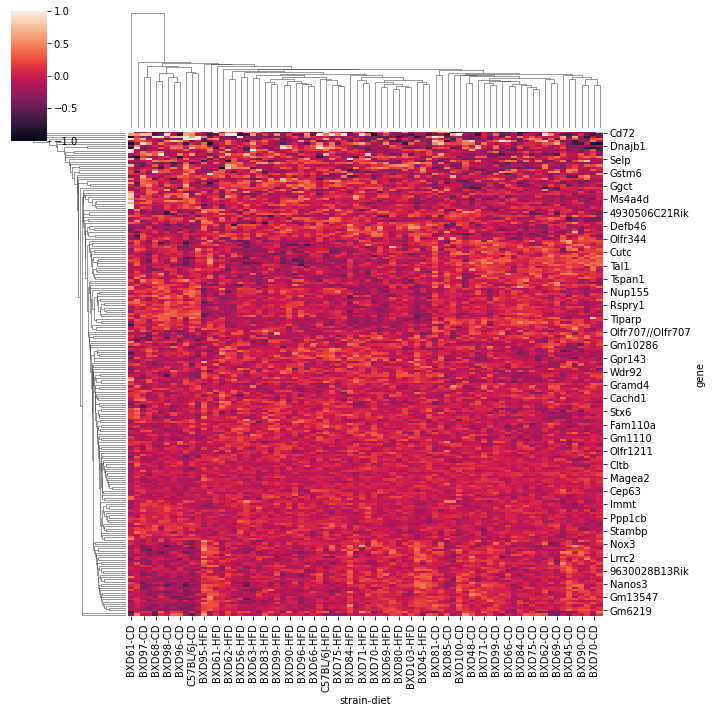

In [39]:
small_gene_normal = small_gene.subtract(small_gene.mean(axis=1), axis=0)
sns.clustermap(small_gene_normal, vmin=-1, vmax=1)

### 5.3: Diverging heatmap, and leaf labels on a dendrogram 
Use a diverging colormap, and center it at zero, so that the neutral midpoint color (black or white) represents the average expression, while the diverging red/blue or red/green colors represent up- and down-regulation.

Limit the scale your heatmap's color bar so that it doesn't get stretched out too much due to a few outliers.

Try to add color labels to the samples to visually distinguish CD and HFD columns easily. Eventually you should arrive at an informative and visually appealing heatmap. With the color labels now displayed, are you happy with the clustering?

In [40]:
# many article doing heatmap with this color map
from matplotlib.colors import LinearSegmentedColormap
cdict  = {
    'red': [[0,1,1],[0.5,0,0],[1,0,0]],
    'green': [[0,0,0],[0.5,0,0],[1,1,1]],
    'blue': [[0,0,0],[1,0,0]]
}
cmap_diverge = LinearSegmentedColormap('custom', segmentdata=cdict , N=256)
colors = ['blue' if diet=='CD' else 'orange' for diet in small_gene_normal.columns.get_level_values(level='diet')]

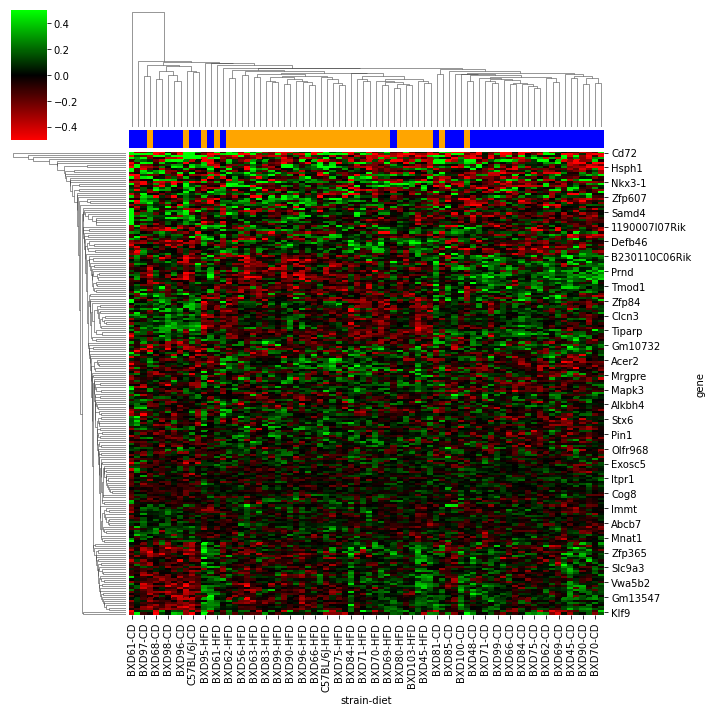

In [41]:
sns.clustermap(small_gene_normal, vmin=-0.5, vmax=0.5, cmap=cmap_diverge, col_colors=colors)

### 5.4: The ultimate heatmap

Now instead of using every 100th row, invent some criteria based on which you can pick the approximately 100-200 most interesting differentially expressed genes, and create a heatmap for them.

It would be best to formulate your criteria such that it results in a binary Series with which you can slice your normalized expression DataFrame. `True` labels for the ones you want to plot on the heatmap, `False` for the rest.

You can also try different linkage methods for the hierarchical clustering (set by `clustermap` parameter `method`).

Tweak your settings and criteria until you are happy with your heatmap, and describe it in a few words.

In [42]:
genes = diffexpr.sort_values(by='mwu pvals corr').index[:200]

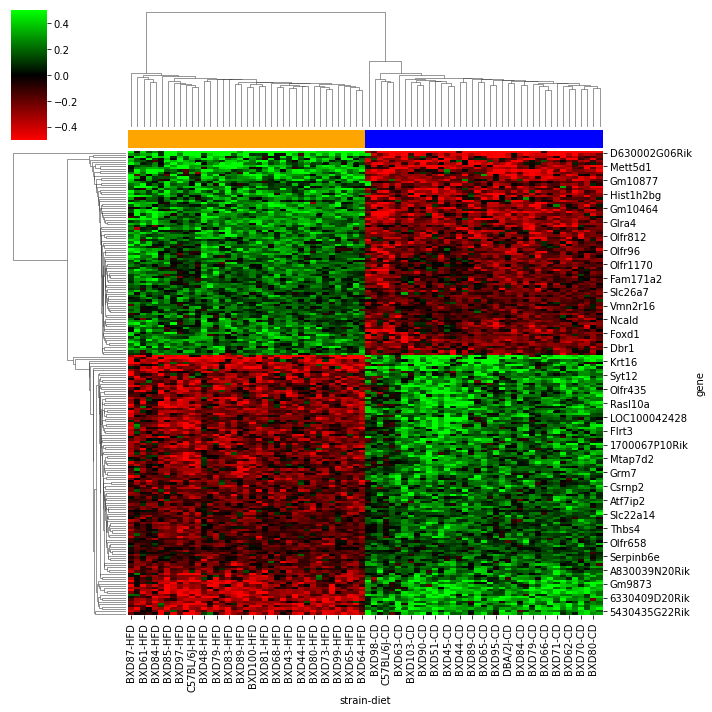

In [43]:
expr3=expr2_trans.loc[genes]
expr3=expr3.subtract(expr3.mean(axis=1), axis=0)
sns.clustermap(expr3, vmin=-0.5, vmax=0.5, cmap=cmap_diverge, col_colors=colors)